In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

%matplotlib inline

In [2]:
# Globals
RED = '#ef4123'
GRAY = '#545453'

# Load and Prepare Data

In [3]:
data = FashionMNIST(root='data/', download=True, transform=ToTensor())

validation_size = 10000
train_size = len(data) - validation_size

train_data, val_data = random_split(data, [train_size, validation_size])

In [4]:
batch_size=128

train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


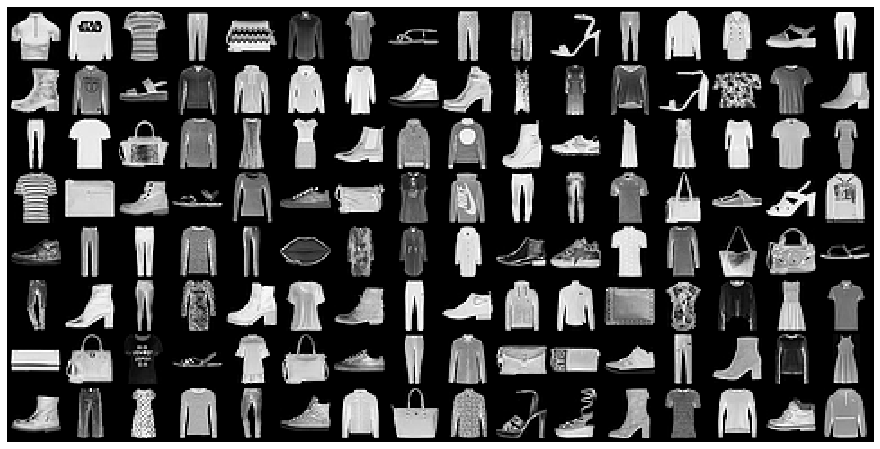

In [5]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Convolutional Neural Network

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
class ModelTrainer():   
    def fit(self, epochs, learning_rate, model, train_loader, val_loader, opt_func=torch.optim.SGD):
        history = []
        optimizer = opt_func(model.parameters(), learning_rate)

        for epoch in range(epochs):
            # Training 
            for batch in train_loader:
                loss = model.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # Validation
            result = self.evaluate(model, val_loader)
            model.epoch_end(epoch, result)
            history.append(result)
            
        return history

    def evaluate(self, model, val_loader):
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

In [8]:
class CNN(nn.Module):
    """Simple Convolutional Neural Network"""
    def __init__(self, accuracy_function):
        super().__init__()
        self.accuracy_function = accuracy_function

        # Create Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        
        # Create Fully Connected Layers
        self.fc1 = nn.Linear(1600, 128) 
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, input_image):
        # Convolution, ReLu and MaxPooling
        output = self.conv1(input_image)
        output = F.relu(output)
        output = F.max_pool2d(output, (2, 2))

        output = self.conv2(output)
        output = F.relu(output)
        output = F.max_pool2d(output, 2)

        # Flatten
        output = output.view(-1, self.num_flat_features(output))
        
        # Fully Connected
        output = self.fc1(output)
        output = F.relu(output)
        output = self.fc2(output)

        return output
    
    def training_step(self, batch):
        # Load batch
        images, labels = batch
        
        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)
        return loss
    
    def validation_step(self, batch):
        # Load batch
        images, labels = batch 

        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)

        # Calculate accuracy
        acc = self.accuracy_function(output, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        
        # Combine losses and return mean value
        epoch_loss = torch.stack(batch_losses).mean()
        
        # Combine accuracies and return mean value
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch: {} - Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, result['val_loss'], \
                                                                                          result['val_acc']))
        
    def num_flat_features(self, image):
        size = image.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
            
        return num_features

In [9]:
def plot_history(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x', color=RED)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x', color=GRAY)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Loss and Accuracy');

In [10]:
input_size = 784
num_classes = 10

model = CNN(accuracy_function=accuracy)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
model_trainer = ModelTrainer()

training_history = []
training_history += model_trainer.fit(5, 0.2, model, train_loader, val_loader)

Epoch: 0 - Validation Loss: 0.4926, Validation Accuracy: 0.8112
Epoch: 1 - Validation Loss: 0.4247, Validation Accuracy: 0.8393
Epoch: 2 - Validation Loss: 0.3714, Validation Accuracy: 0.8667
Epoch: 3 - Validation Loss: 0.3304, Validation Accuracy: 0.8729
Epoch: 4 - Validation Loss: 0.3397, Validation Accuracy: 0.8689


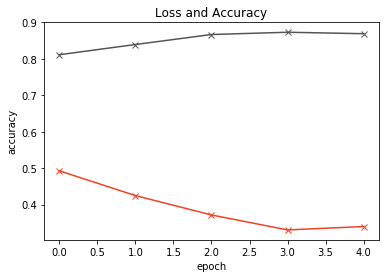

In [12]:
plot_history(training_history)

In [13]:
torch.save(model.state_dict(), os.path.join('.\models', 'cnn.pth'))

NameError: name 'os' is not defined